In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [5]:
# ============================================
# 1. LOAD AND EXPLORE DATA
# ============================================

def load_data(filepath):
    """Load dataset from CSV file"""
    df = pd.read_csv(filepath)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

def explore_data(df):
    """Display basic information about the dataset"""
    print("\n--- Dataset Info ---")
    print(df.info())

    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- Statistical Summary ---")
    print(df.describe())

    print("\n--- Missing Values ---")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

    return df

# Load dataset
df = load_data('clusteringmidterm.csv')
df = explore_data(df)

Dataset loaded: 8950 rows, 18 columns

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVA

In [6]:
# ============================================
# 2. DATA PREPROCESSING
# ============================================

def preprocess_data(df):
    """Clean and prepare data for clustering"""
    # Make a copy
    df_processed = df.copy()

    # Remove customer ID (not useful for clustering)
    if 'CUST_ID' in df_processed.columns:
        df_processed = df_processed.drop('CUST_ID', axis=1)
        print("✓ Customer ID removed")

    # Handle missing values
    if df_processed.isnull().sum().sum() > 0:
        # Fill with median
        df_processed = df_processed.fillna(df_processed.median())
        print("✓ Missing values filled with median")
    else:
        print("✓ No missing values found")

    # Check for duplicates
    duplicates = df_processed.duplicated().sum()
    if duplicates > 0:
        df_processed = df_processed.drop_duplicates()
        print(f"✓ {duplicates} duplicates removed")
    else:
        print("✓ No duplicates found")

    print(f"\nFinal shape: {df_processed.shape}")
    return df_processed

# Preprocess data
df_clean = preprocess_data(df)

✓ Customer ID removed
✓ Missing values filled with median
✓ No duplicates found

Final shape: (8950, 17)


In [7]:
# ============================================
# 3. FEATURE SCALING
# ============================================

def scale_features(df):
    """Standardize features using StandardScaler"""
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Convert back to DataFrame for easier handling
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    print("✓ Features scaled using StandardScaler")
    print(f"Scaled data shape: {df_scaled.shape}")

    return df_scaled, scaler

# Scale features
df_scaled, scaler = scale_features(df_clean)

# Display scaled data
print("\n--- Scaled Data Sample ---")
print(df_scaled.head())

✓ Features scaled using StandardScaler
Scaled data shape: (8950, 17)

--- Scaled Data Sample ---
    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1    

Finding optimal number of clusters...
k=2: Inertia=127784.53, Silhouette=0.210
k=3: Inertia=111975.04, Silhouette=0.251
k=4: Inertia=99061.94, Silhouette=0.198
k=5: Inertia=91490.50, Silhouette=0.193
k=6: Inertia=84826.59, Silhouette=0.203
k=7: Inertia=79856.16, Silhouette=0.208
k=8: Inertia=74484.88, Silhouette=0.222


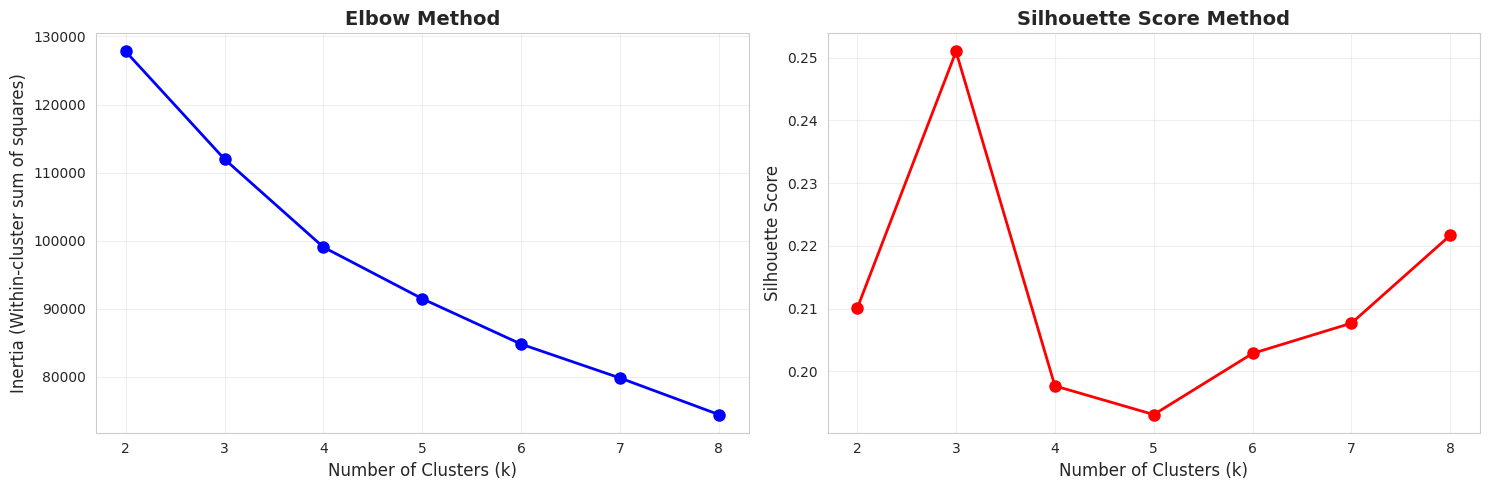


✓ Optimal number of clusters: 3 (based on Silhouette Score)


In [8]:
# ============================================
# 4. DETERMINE OPTIMAL NUMBER OF CLUSTERS
# ============================================

def find_optimal_clusters(data, max_k=10):
    """Use Elbow Method and Silhouette Score to find optimal k"""
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)

    print("Finding optimal number of clusters...")

    for k in K_range:
        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)

        # Calculate metrics
        inertias.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

        print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={score:.3f}")

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Elbow plot
    axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
    axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Silhouette plot
    axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title('Silhouette Score Method', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find best k based on silhouette score
    best_k = K_range[np.argmax(silhouette_scores)]
    print(f"\n✓ Optimal number of clusters: {best_k} (based on Silhouette Score)")

    return best_k

# Find optimal k
optimal_k = find_optimal_clusters(df_scaled, max_k=8)

In [9]:
# ============================================
# 5. TRAIN K-MEANS MODEL
# ============================================

def train_kmeans_model(data, n_clusters):
    """Train K-Means clustering model"""
    print(f"\nTraining K-Means with {n_clusters} clusters...")

    # Initialize and fit model
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42
    )

    # Fit model and predict clusters
    cluster_labels = kmeans.fit_predict(data)

    print("✓ Model trained successfully")

    return kmeans, cluster_labels

# Train model
kmeans_model, clusters = train_kmeans_model(df_scaled, optimal_k)

# Add cluster labels to original data
df_clean['Cluster'] = clusters

print(f"\n--- Cluster Distribution ---")
print(df_clean['Cluster'].value_counts().sort_index())


Training K-Means with 3 clusters...
✓ Model trained successfully

--- Cluster Distribution ---
Cluster
0    1275
1    6114
2    1561
Name: count, dtype: int64


In [10]:
# ============================================
# 6. MODEL EVALUATION
# ============================================

def evaluate_clustering(data, labels, model):
    """Evaluate clustering model performance"""
    print("\n=== CLUSTERING EVALUATION METRICS ===\n")

    # Silhouette Score
    silhouette = silhouette_score(data, labels)
    print(f"Silhouette Score: {silhouette:.4f}")
    print("  → Range: [-1, 1], Higher is better")
    print(f"  → Interpretation: {'Good' if silhouette > 0.5 else 'Fair' if silhouette > 0.3 else 'Poor'}")

    # Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(data, labels)
    print(f"\nDavies-Bouldin Index: {davies_bouldin:.4f}")
    print("  → Lower is better")
    print(f"  → Interpretation: {'Good' if davies_bouldin < 1 else 'Fair' if davies_bouldin < 2 else 'Poor'}")

    # Inertia
    inertia = model.inertia_
    print(f"\nInertia (Within-cluster sum of squares): {inertia:.2f}")
    print("  → Lower is better (compact clusters)")

    print("\n" + "="*40)

    return {
        'silhouette_score': silhouette,
        'davies_bouldin_index': davies_bouldin,
        'inertia': inertia
    }

# Evaluate model
metrics = evaluate_clustering(df_scaled, clusters, kmeans_model)


=== CLUSTERING EVALUATION METRICS ===

Silhouette Score: 0.2510
  → Range: [-1, 1], Higher is better
  → Interpretation: Poor

Davies-Bouldin Index: 1.5920
  → Lower is better
  → Interpretation: Fair

Inertia (Within-cluster sum of squares): 111975.04
  → Lower is better (compact clusters)



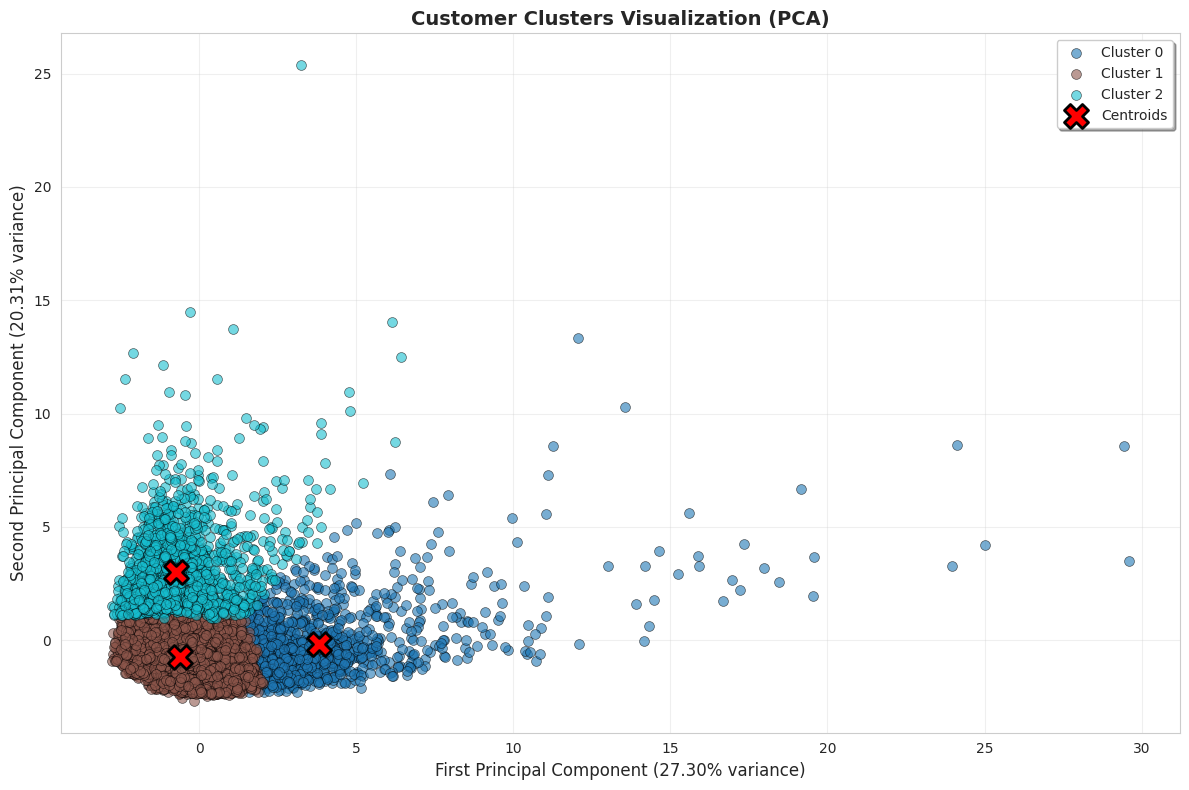

✓ Total variance explained by 2 components: 47.61%


In [11]:
# ============================================
# 7. CLUSTER VISUALIZATION
# ============================================

def visualize_clusters_pca(data, labels, model):
    """Visualize clusters using PCA for dimensionality reduction"""
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(data)

    # Create DataFrame for plotting
    df_pca = pd.DataFrame(
        data_pca,
        columns=['PC1', 'PC2']
    )
    df_pca['Cluster'] = labels

    # Plot
    plt.figure(figsize=(12, 8))

    # Scatter plot for each cluster
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels))))

    for i, color in zip(np.unique(labels), colors):
        cluster_data = df_pca[df_pca['Cluster'] == i]
        plt.scatter(
            cluster_data['PC1'],
            cluster_data['PC2'],
            c=[color],
            label=f'Cluster {i}',
            s=50,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )

    # Plot cluster centers
    centers_pca = pca.transform(model.cluster_centers_)
    plt.scatter(
        centers_pca[:, 0],
        centers_pca[:, 1],
        c='red',
        marker='X',
        s=300,
        edgecolors='black',
        linewidth=2,
        label='Centroids',
        zorder=10
    )

    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.title('Customer Clusters Visualization (PCA)', fontsize=14, fontweight='bold')
    plt.legend(loc='best', frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"✓ Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

# Visualize clusters
visualize_clusters_pca(df_scaled, clusters, kmeans_model)


=== CLUSTER CHARACTERISTICS ===

             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        2182.352833           0.981702  4187.017796       2663.995153   
1         807.722510           0.834577   496.062522        247.273214   
2        4023.788865           0.959193   389.051448        252.333261   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                   1523.493231    449.753140             0.948175   
1                    249.110368    338.996760             0.460353   
2                    136.797412   3917.254973             0.233899   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                          0.664780                          0.739630   
1                        

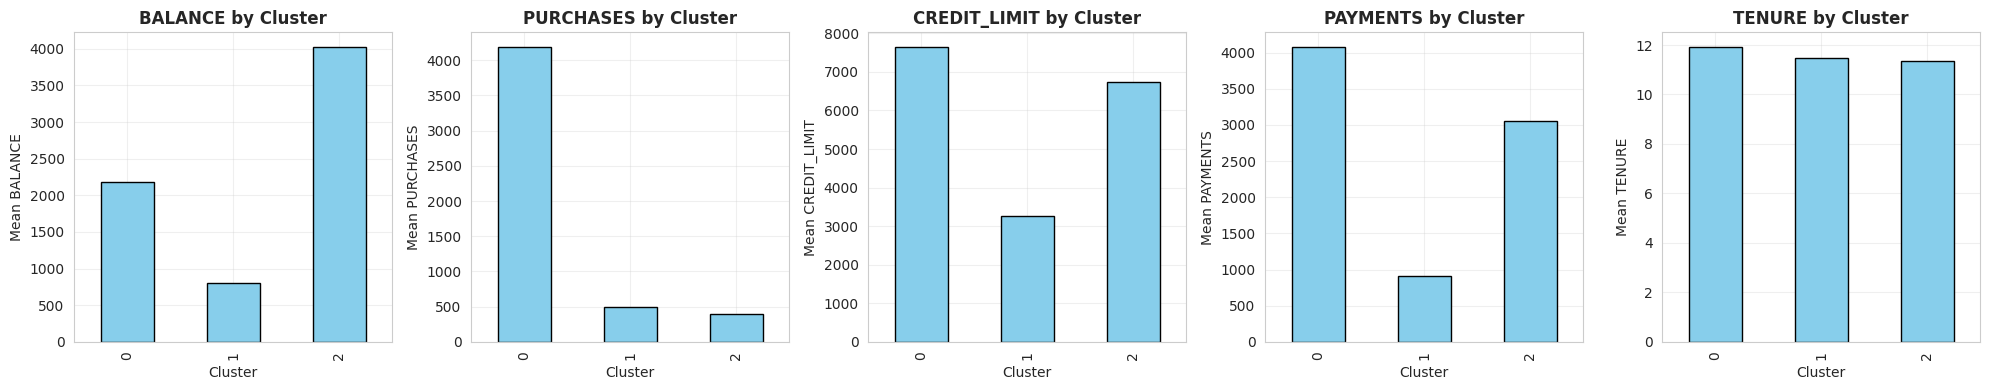

In [12]:
# ============================================
# 8. CLUSTER CHARACTERISTICS ANALYSIS
# ============================================

def analyze_cluster_characteristics(df_original, cluster_labels):
    """Analyze and compare characteristics of each cluster"""
    # Add cluster labels
    df_analysis = df_original.copy()
    df_analysis['Cluster'] = cluster_labels

    # Calculate mean for each cluster
    cluster_means = df_analysis.groupby('Cluster').mean()

    print("\n=== CLUSTER CHARACTERISTICS ===\n")
    print(cluster_means)

    # Visualize top features for each cluster
    top_features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'TENURE']

    # Check which features exist
    available_features = [f for f in top_features if f in df_analysis.columns]

    if available_features:
        fig, axes = plt.subplots(1, len(available_features), figsize=(20, 4))

        for idx, feature in enumerate(available_features):
            cluster_means[feature].plot(kind='bar', ax=axes[idx], color='skyblue', edgecolor='black')
            axes[idx].set_title(f'{feature} by Cluster', fontweight='bold')
            axes[idx].set_xlabel('Cluster')
            axes[idx].set_ylabel(f'Mean {feature}')
            axes[idx].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return cluster_means

# Analyze clusters
cluster_characteristics = analyze_cluster_characteristics(df_clean.drop('Cluster', axis=1), clusters)

In [13]:
# ============================================
# 9. CONCLUSIONS AND INSIGHTS
# ============================================

def generate_cluster_insights(df_with_clusters, cluster_means):
    """Generate insights about each cluster"""
    print("\n" + "="*60)
    print("CLUSTER INSIGHTS AND BUSINESS RECOMMENDATIONS")
    print("="*60 + "\n")

    for cluster_id in sorted(df_with_clusters['Cluster'].unique()):
        cluster_size = len(df_with_clusters[df_with_clusters['Cluster'] == cluster_id])
        percentage = (cluster_size / len(df_with_clusters)) * 100

        print(f"CLUSTER {cluster_id}:")
        print(f"  Size: {cluster_size} customers ({percentage:.1f}%)")

        # Get characteristics for this cluster
        if 'BALANCE' in cluster_means.columns:
            balance = cluster_means.loc[cluster_id, 'BALANCE']
            print(f"  Average Balance: ${balance:.2f}")

        if 'PURCHASES' in cluster_means.columns:
            purchases = cluster_means.loc[cluster_id, 'PURCHASES']
            print(f"  Average Purchases: ${purchases:.2f}")

        if 'CREDIT_LIMIT' in cluster_means.columns:
            credit = cluster_means.loc[cluster_id, 'CREDIT_LIMIT']
            print(f"  Average Credit Limit: ${credit:.2f}")

        print()

    print("="*60)
    print("\nKEY FINDINGS:")
    print("1. Customers are segmented into distinct groups based on behavior")
    print("2. Each cluster shows unique spending and payment patterns")
    print("3. Model can be used for targeted marketing strategies")
    print("="*60)

# Generate insights
generate_cluster_insights(df_clean, cluster_characteristics)


CLUSTER INSIGHTS AND BUSINESS RECOMMENDATIONS

CLUSTER 0:
  Size: 1275 customers (14.2%)
  Average Balance: $2182.35
  Average Purchases: $4187.02
  Average Credit Limit: $7642.78

CLUSTER 1:
  Size: 6114 customers (68.3%)
  Average Balance: $807.72
  Average Purchases: $496.06
  Average Credit Limit: $3267.02

CLUSTER 2:
  Size: 1561 customers (17.4%)
  Average Balance: $4023.79
  Average Purchases: $389.05
  Average Credit Limit: $6729.47


KEY FINDINGS:
1. Customers are segmented into distinct groups based on behavior
2. Each cluster shows unique spending and payment patterns
3. Model can be used for targeted marketing strategies


In [14]:
# ============================================
# 10. SUMMARY
# ============================================

print("\n" + "="*60)
print("CLUSTERING PROJECT SUMMARY")
print("="*60)
print(f"\n✓ Dataset: Credit Card Customer Data")
print(f"✓ Total Samples: {len(df_clean)}")
print(f"✓ Total Features: {len(df_clean.columns) - 1}")  # Exclude Cluster column
print(f"✓ Algorithm: K-Means Clustering")
print(f"✓ Optimal Clusters: {optimal_k}")
print(f"✓ Silhouette Score: {metrics['silhouette_score']:.4f}")
print(f"✓ Davies-Bouldin Index: {metrics['davies_bouldin_index']:.4f}")
print("\n" + "="*60)
print("\nPROJECT COMPLETED SUCCESSFULLY!")
print("="*60)


CLUSTERING PROJECT SUMMARY

✓ Dataset: Credit Card Customer Data
✓ Total Samples: 8950
✓ Total Features: 17
✓ Algorithm: K-Means Clustering
✓ Optimal Clusters: 3
✓ Silhouette Score: 0.2510
✓ Davies-Bouldin Index: 1.5920


PROJECT COMPLETED SUCCESSFULLY!
